In [ ]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import shutil, time, re, mne, matplotlib, torch, os, sys
from torch import nn
from torch.utils.data import Dataset, DataLoader
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from modd.datasets import *
from modd.transformer import *

### Obtención de gráfica para un individuo y consenso de anotaciones

In [2]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from modd.datasets import *
# Test dataset
dataset = EegDataset()
dataset_nominal = EegDatasetNominal()
# dataset.plot(3)
# dataset_nominal.plot(3)

e:\Drive-Seba\UChile\10mo semestre\Teoria de la Información\Mismodelling-on-Time-Series\modd\datasets.py:18: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload=True, verbose=False)


(3761, 21, 256)


e:\Drive-Seba\UChile\10mo semestre\Teoria de la Información\Mismodelling-on-Time-Series\modd\datasets.py:18: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload=True, verbose=False)


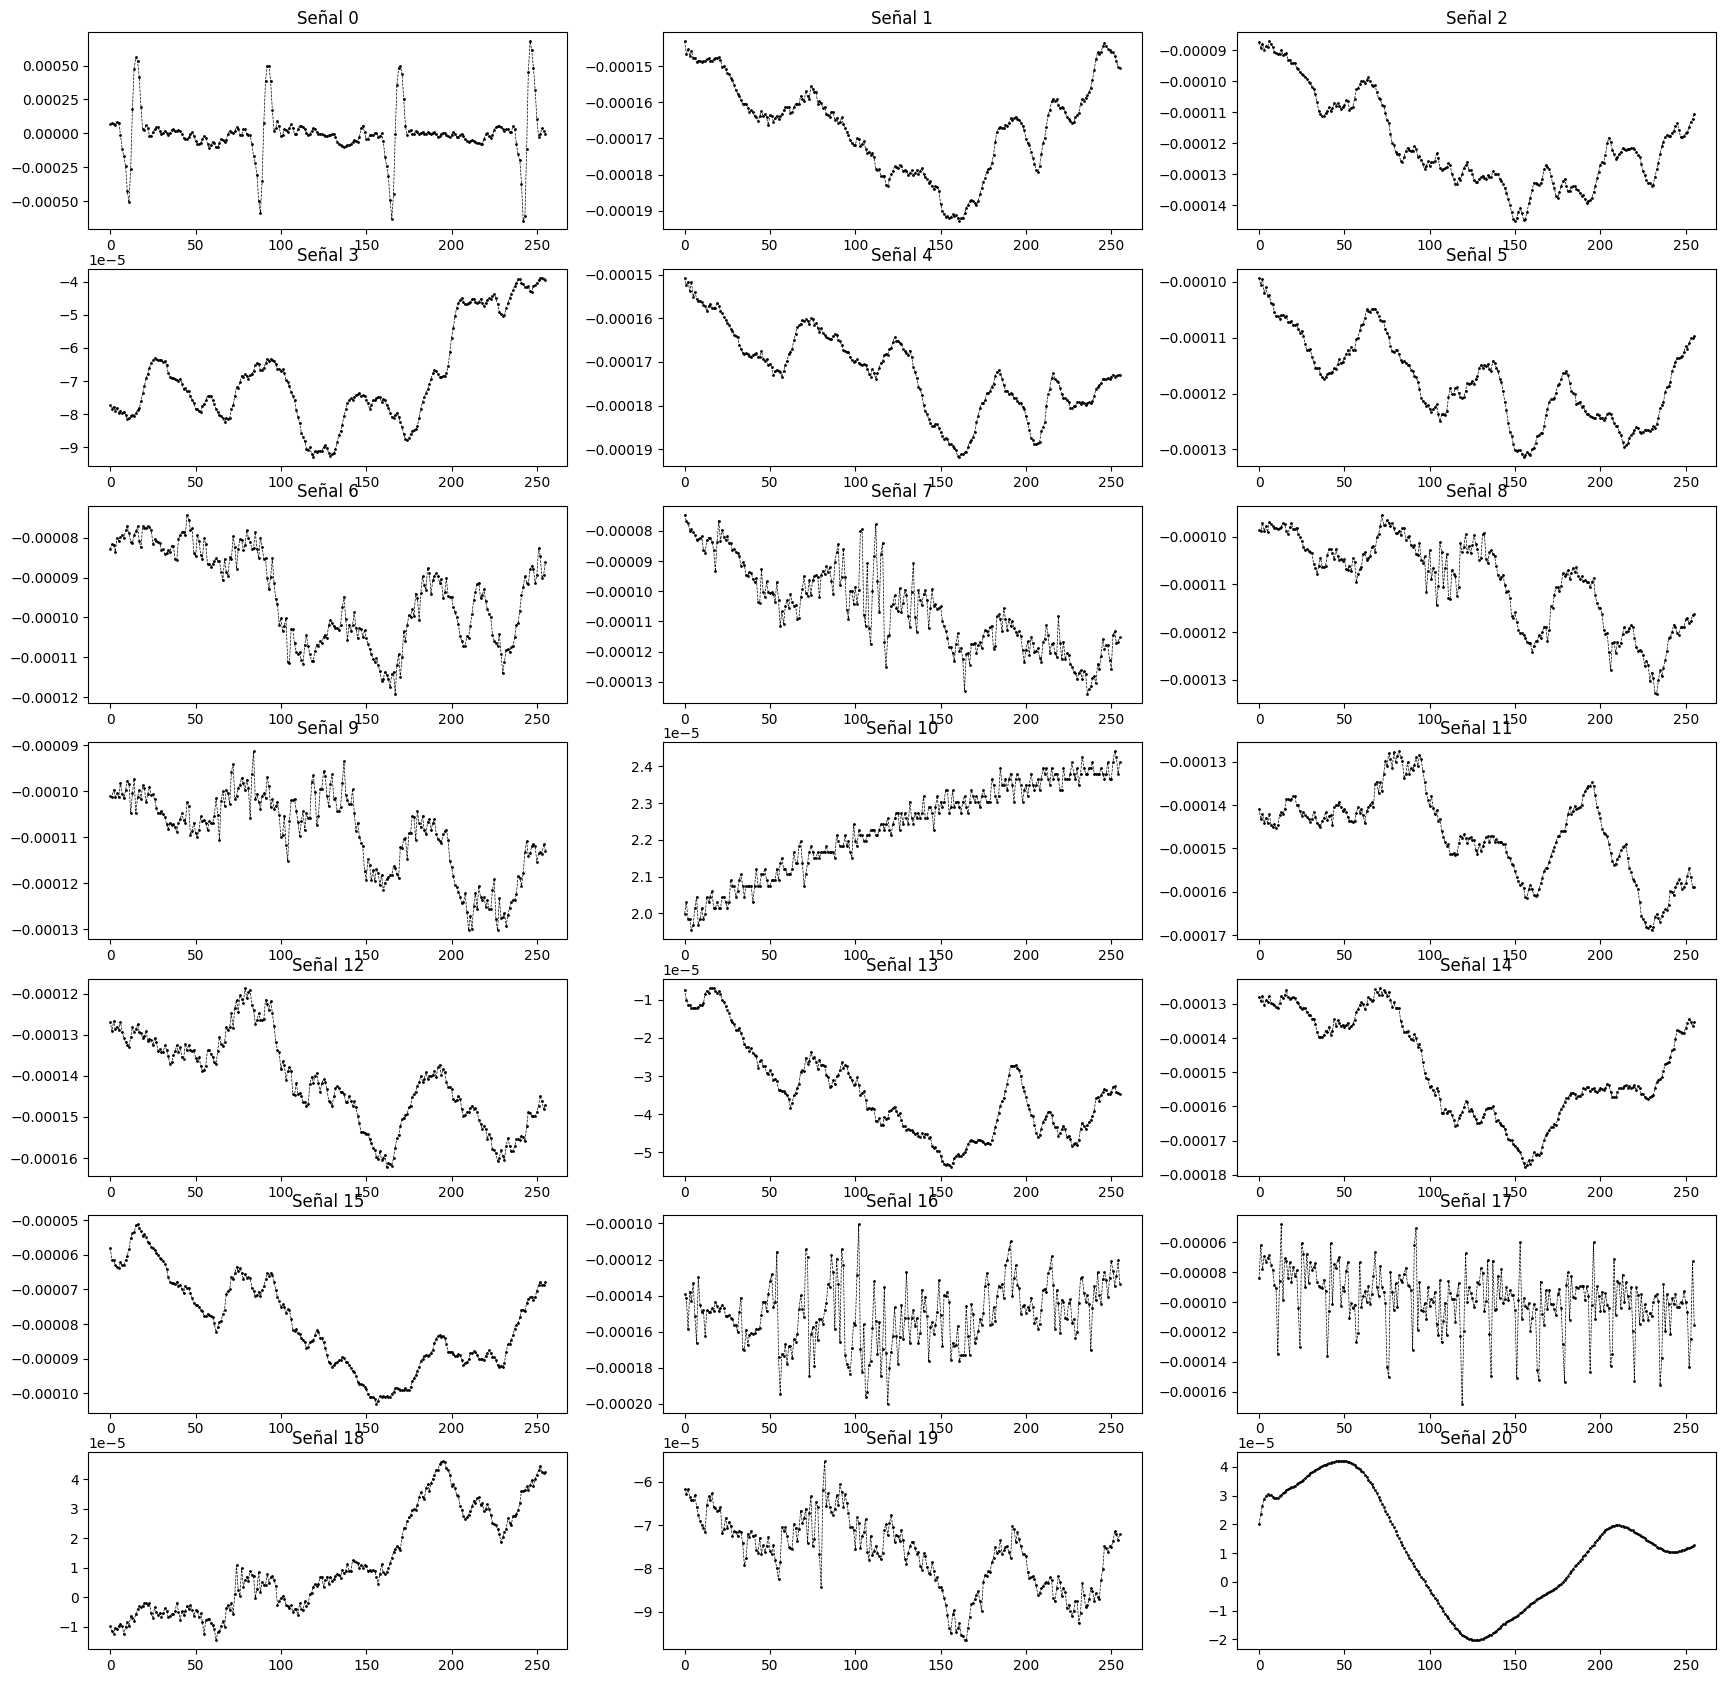

In [3]:
# Printear las dimensiones de los datos
# dataset_nominal[0] ((segmentos:N_variable, canales:21, muestras:256), anotaciones)
# dataset_nominal[0][0] señales: (segmentos, canales, muestras)
print(dataset_nominal[0][0].shape)
segmento = dataset_nominal[0][0][0]
fig, axs = plt.subplots(7, 3, figsize=(21, 21))
for i in range(7):
    for j in range(3):
        # graficar los puntos
        axs[i, j].plot(segmento[i*3+j], color='black',marker='o', linestyle='dashed',linewidth=0.5, markersize=1)
        axs[i, j].set_title("Señal "+str(i*3+j))
plt.show()

In [4]:
dataset_nominal = EegDatasetNominal()
dataset_nominal.columns[14]

'35'

In [5]:
dataset = EegDataset()
dataset_nominal = EegDatasetNominal()
# Separar en train 70, val 10, test 20
train_len = int(len(dataset_nominal)*0.8)
val_len = int(len(dataset_nominal)*0.1)
test_len = len(dataset_nominal) - train_len - val_len
print(" Train: ", round(train_len/len(dataset_nominal) * 100, 2), "% -> ", train_len)
print(" Val: ", round(val_len/len(dataset_nominal) * 100, 2), "% -> ", val_len)
print(" Test: ", round(test_len/len(dataset_nominal) * 100, 2), "% -> ", test_len)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_nominal, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))

 Train:  78.79 % ->  26
 Val:  9.09 % ->  3
 Test:  12.12 % ->  4


In [6]:
# Clear output console
from IPython.display import clear_output
# X son las secuencias y Y son las secuencias del instante siguiente
def create_data(dataset):
    X, Y = [], []
    for i in range(len(dataset)):
        segments = dataset[i][0]
        for j in range(len(segments)-1):
            X.append(segments[j])  # Convierte a float32
            Y.append(segments[j+1])  # Convierte a float32
    return np.transpose(np.stack(X), (0, 2, 1)).astype(np.float32), np.transpose(np.stack(Y), (0, 2, 1)).astype(np.float32)
# Crear los datasets
X_test, Y_test = create_data(test_dataset)
X_train, Y_train = create_data(train_dataset)
X_val, Y_val = create_data(val_dataset)

e:\Drive-Seba\UChile\10mo semestre\Teoria de la Información\Mismodelling-on-Time-Series\modd\datasets.py:18: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload=True, verbose=False)
e:\Drive-Seba\UChile\10mo semestre\Teoria de la Información\Mismodelling-on-Time-Series\modd\datasets.py:18: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload=True, verbose=False)
e:\Drive-Seba\UChile\10mo semestre\Teoria de la Información\Mismodelling-on-Time-Series\modd\datasets.py:18: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload=True, verbose=False)
e:\Drive-Seba\UChile\10mo semestre\Teoria de la Información\Mismodelling-on-Time-Series\modd\datasets.py:18: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload=True, verbose=False)
e:\Drive-Seba\UChile\10mo semestre\Teori

In [7]:
for i in range(len(X_test)):
    print(X_test[i].shape)
    break

(256, 21)


In [8]:
# Guardar datos en un archivo
path = '../transformer_data/'
# torch.save(X_train, path+'X_train.pt')
# torch.save(Y_train, path+'Y_train.pt')
# torch.save(X_val, path+'X_val.pt')
# torch.save(Y_val, path+'Y_val.pt')
# torch.save(X_test, path+'X_test.pt')
# torch.save(Y_test, path+'Y_test.pt')

In [9]:
# Obtener la media y desviación estándar de los datos de train por cada canal (21), X_train: (batch_size, seq_len, channels)
X_train_mean = np.mean(X_train, axis=(0, 1))
X_train_std = np.std(X_train, axis=(0, 1))
# Normalizar los datos de train, val y test
def normalize(data, mean, std): return (data - mean) / std
X_train_n = normalize(X_train, X_train_mean, X_train_std)
X_val_n = normalize(X_val, X_train_mean, X_train_std)
X_test_n = normalize(X_test, X_train_mean, X_train_std)
Y_train_n = normalize(Y_train, X_train_mean, X_train_std)
Y_val_n = normalize(Y_val, X_train_mean, X_train_std)
Y_test_n = normalize(Y_test, X_train_mean, X_train_std)

In [10]:
import torchvision.transforms as transforms

# Crear un dataset con los datos de train y test
class EegDatasetNominalPairs(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.X[idx])[0], self.transform(self.Y[idx])[0]
        return self.X[idx], self.Y[idx]
# Pasar de Float64 a Float32
transform = transforms.Compose([transforms.ToTensor()])


# Crear los datasets de train y test
train_dataset = EegDatasetNominalPairs(X_train_n, Y_train_n, transform=transform)
val_dataset = EegDatasetNominalPairs(X_val_n, Y_val_n, transform=transform)
test_dataset = EegDatasetNominalPairs(X_test_n, Y_test_n, transform=transform)

In [104]:
m = nn.Transformer()
mask = m.generate_square_subsequent_mask(10)
print(mask)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import math

class Transformer(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward, dropout=0.1, max_length=256, channels=21):
        super(Transformer, self).__init__()
        self.embedding = nn.Linear(channels, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True, activation='gelu')#, norm_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.positional_encoding = self.generate_positional_encoding(d_model, max_length)
        self.decoder = nn.Linear(d_model, channels)
    
    def forward(self, x):
        # x : (batch_size, seq_len, d_model), pos_enc: (1, seq_len, d_model), mask: (batch_size, seq_len, seq_len)
        b, s, c = x.shape
        x = self.embedding(x)
        # Checkear que ningun valor es nan
        assert not torch.any(torch.isnan(x))
        x = x + self.positional_encoding[:x.size(1), :].unsqueeze(0).to(x.device)
        assert not torch.any(torch.isnan(x))
        causal_mask = self.generate_causal_mask(s).to(x.device)
        x = self.transformer_encoder(src=x,is_causal = True, src_key_padding_mask=None, mask=nn.Transformer().generate_square_subsequent_mask(s).to(x.device))
        assert not torch.any(torch.isnan(x))
        x = self.decoder(x)
        assert not torch.any(torch.isnan(x))
        return x

    def generate_causal_mask(self, seq_len):
        # mask = torch.ones(seq_len, seq_len)
        # mask = torch.tril(mask, diagonal=0)
        # return mask
        # Usar -inf 
        mask = torch.ones(seq_len, seq_len) * -float('inf')
        mask = torch.tril(mask, diagonal=0)
        return mask
        

    def generate_positional_encoding(self, d_model, max_length): # Attention is all you need
        pe = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) # ej: 0::2 -> 0, 2, 4, 6, 8, ...
        pe[:, 1::2] = torch.cos(position * div_term) # ej: 1::2 -> 1, 3, 5, 7, 9, ...
        return pe

class TransformerModel(pl.LightningModule):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward, dropout=0.1, learning_rate=1e-3, loss_fn=nn.MSELoss( reduction='sum')):
        super(TransformerModel, self).__init__()
        self.model = Transformer(d_model, nhead, num_layers, dim_feedforward)
        self.learning_rate = learning_rate  # Agrega el hiperparámetro learning_rate
        self.loss_function = loss_fn

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = self.loss_function(output, y)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = self.loss_function(output, y)
        self.log('val/loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)
    
# Crear una instancia del modelo con hiperparámetros personalizables (d_model % nhead = 0)
model = TransformerModel(d_model=40, nhead=4, num_layers=4, dim_feedforward=1024, dropout=0.1, learning_rate=1e-5)
model.eval()
# Plotear máscara
x = torch.randn(64, 256, 21)
y = model(x)

In [122]:
print(train_dataset[0][1].shape, train_dataset[0][0].dtype)
y = model(train_dataset[0][0].unsqueeze(0))

torch.Size([256, 21]) torch.float32


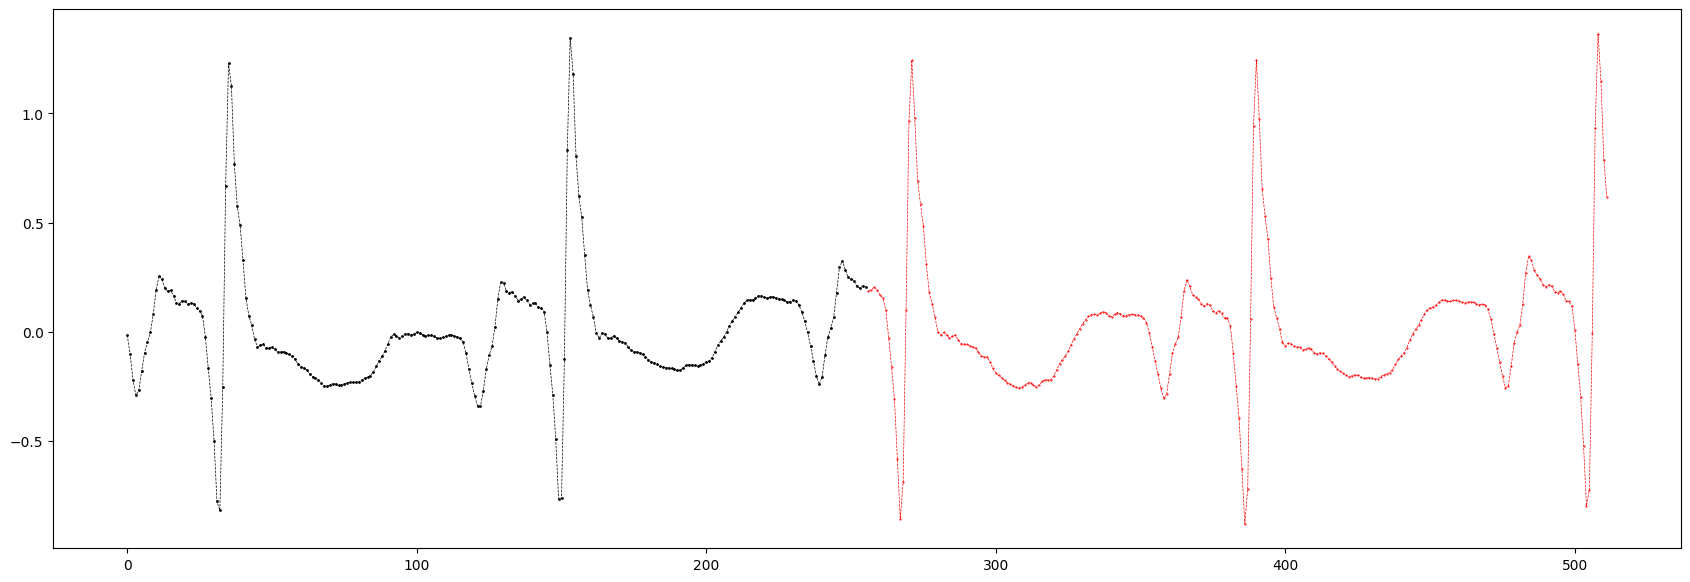

In [123]:
# Verificar que los datos sean correctos
fig, ax = plt.subplots(1, 1, figsize=(21, 7))
ax.plot(train_dataset[0][0][:, 0], color='black',marker='o', linestyle='dashed',linewidth=0.5, markersize=1)
ax.plot(np.arange(0, 256)+256, train_dataset[0][1][:, 0], color='red',marker='.', linestyle='dashed',linewidth=0.5, markersize=1)
plt.show()

In [124]:
# Armar data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [130]:
# Entrenar el modelo
hparams = dict(
    d_model=100,
    nhead=10,
    num_layers=4,
    dim_feedforward=512,
    dropout=0.1,
    learning_rate=1e-5,
    loss_fn=nn.MSELoss()
)
torch.set_float32_matmul_precision('medium')
model = TransformerModel(**hparams)
%load_ext tensorboard
# Entrenar el modelo
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=120,
    logger=pl.loggers.TensorBoardLogger("lightning_logs", name="tst"),
    callbacks=[
        # puede usar early stopping si desea
        pl.callbacks.EarlyStopping(monitor="val/loss", patience=15, verbose=False, mode="min"),
        # puede usar esto si usa un scheduler :
        pl.callbacks.LearningRateMonitor(logging_interval='step'),
        # Guardar el mejor modelo
        pl.callbacks.ModelCheckpoint(monitor="val/loss", mode="min", save_top_k=1), # Monitoreamos la kl_loss ya que la loss sube
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [131]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type        | Params
----------------------------------------------
0 | model         | Transformer | 579 K 
1 | loss_function | MSELoss     | 0     
----------------------------------------------
579 K     Trainable params
0         Non-trainable params
579 K     Total params
2.318     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=120` reached.


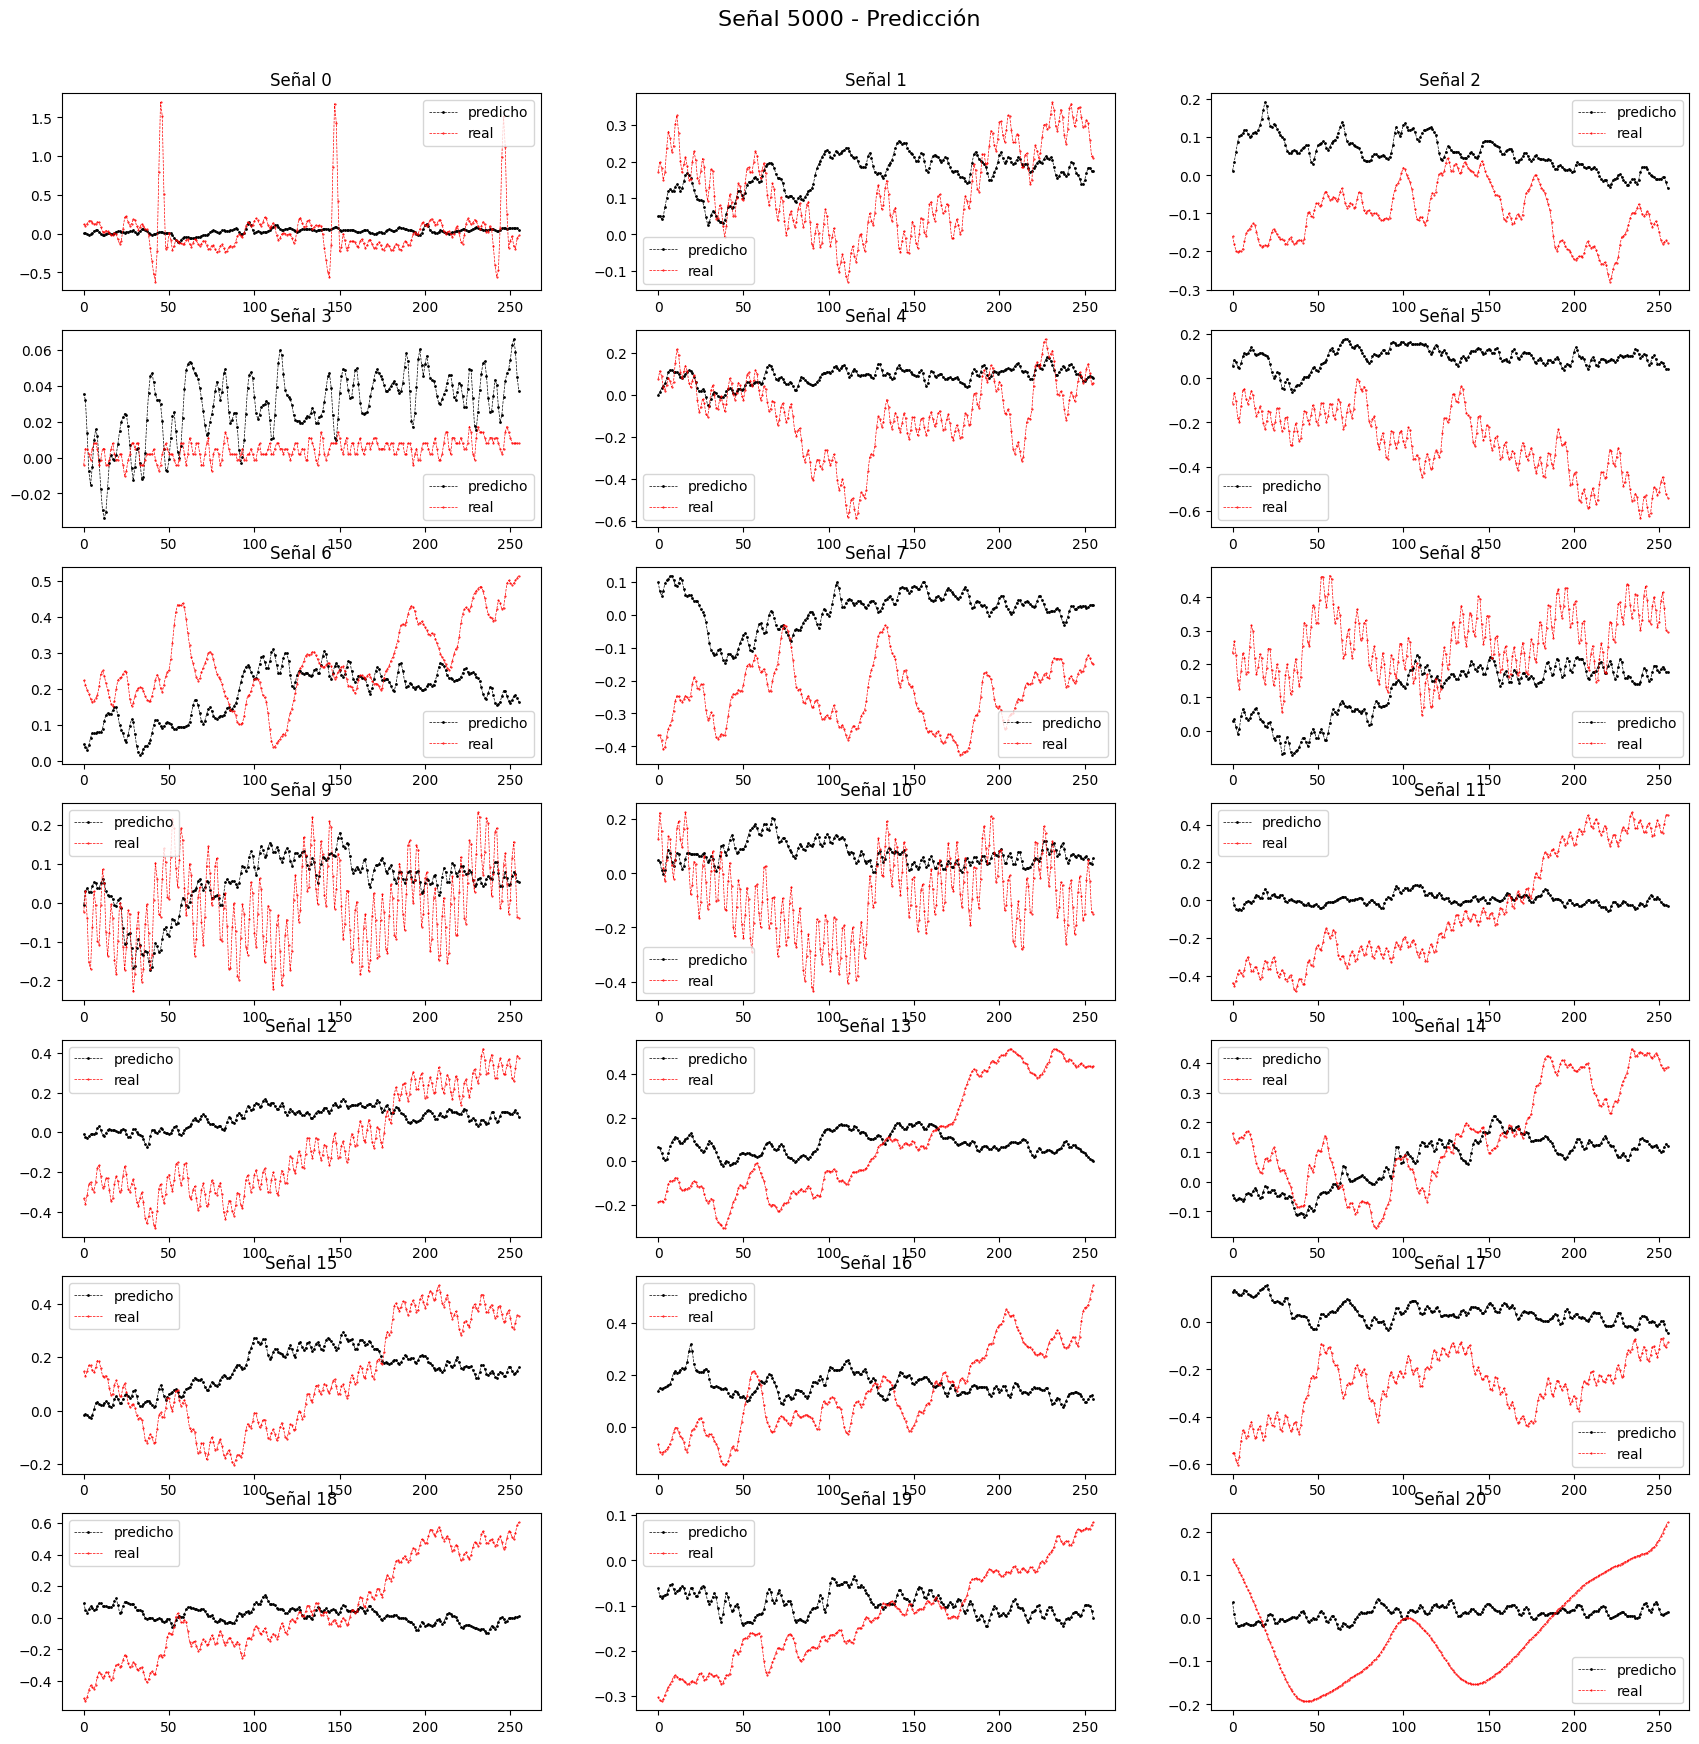

In [143]:
# Evaluar el modelo en un dato de test ( con labels de real y predicho)
model.eval()
dato = 5000
x, y = train_dataset[dato]
output = model(x.unsqueeze(0))
fig, ax = plt.subplots(7, 3, figsize=(21, 21))
for i in range(7):
    for j in range(3):
        # graficar los puntos
        ax[i, j].plot(output.detach().numpy()[0, :, i*3+j], color='black',marker='o', linestyle='dashed',linewidth=0.5, markersize=1, label='predicho')
        ax[i, j].plot(y[:, i*3+j], color='red',marker='.', linestyle='dashed',linewidth=0.5, markersize=1, label='real')
        ax[i, j].set_title("Señal "+str(i*3+j))
        ax[i, j].legend()
# Titulo
fig.suptitle(f"Señal {dato} - Predicción", fontsize=16, y=0.92)
plt.show()

Text(0.5, 1.0, 'Curva de aprendizaje')

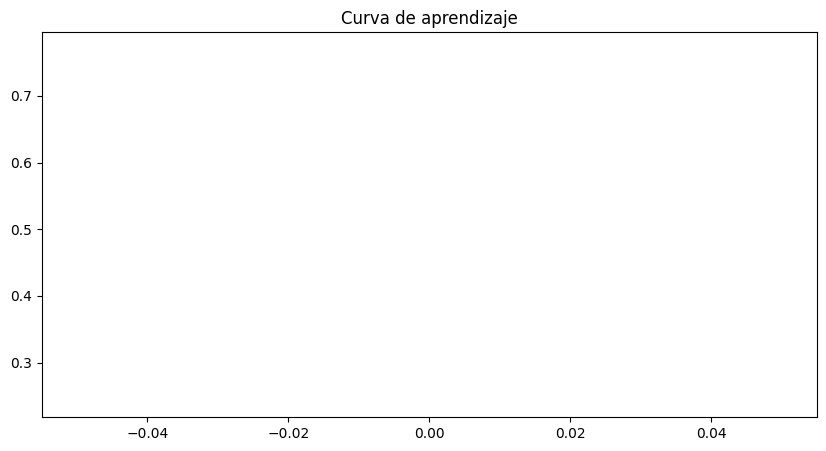

In [142]:
# Graficar curva de aprendizaje
plt.figure(figsize=(10, 5))
plt.plot(trainer.callback_metrics['train/loss'])
plt.plot(trainer.callback_metrics['val/loss'])
plt.title('Curva de aprendizaje')
